In [1]:
import os
import sys
import pickle
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import models

from PIL import Image
import torchvision.utils as vutils

import random
from tqdm import tqdm
import matplotlib.pyplot as plt

def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3Q
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6
    


In [2]:
manual_seed(42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 1048

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((32,32)),
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data',train=True, download=False, transform=train_transforms)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True,drop_last=True)

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((32,32)),
])

val_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False,download=False ,transform=val_transforms)
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

print(len(val_dataset.data), len(val_loader))


10000 9


## VAE 학습
pretrain 한 layer를 넣어서

In [5]:
EPOCHS = 100
# LR = 1e-4
LR = 1e-4
LATENT_DIM = 2

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
encoder = models.Encoder(LATENT_DIM)
decoder = models.Decoder(LATENT_DIM)
model = models.VAEMLP(encoder, decoder)
# model.apply(weights_init)
print(model)

VAEMLP(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (z_mean): Linear(in_features=500, out_features=2, bias=True)
    (z_logvar): Linear(in_features=500, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=500, out_features=784, bias=True)
    )
  )
)


In [8]:
pretrained = torch.load('./check/clacheckpoint.pth')['model_state_dict']
init_dict = dict()
for key, val in pretrained.items():
    print(key)
    if key.startswith('layers.'):
        new_key = 'encoder.'+key
        init_dict[new_key] = val
if len(init_dict)==0:
    print(f"no weights to transfer.")
else:
    model.load_state_dict(init_dict, strict=False)
    print(f"initialize wieghts from pretrained classifier : {init_dict.keys()}")
    


layers.0.weight
layers.0.bias
fc2.weight
fc2.bias
initialize wieghts from pretrained classifier : dict_keys(['encoder.layers.0.weight', 'encoder.layers.0.bias'])


In [9]:
def kl_function(mean, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return KLD
MSE_loss = nn.MSELoss(reduction='sum')
KL_loss = kl_function

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

0 EPOCH - MSE : 105.66033, KL : 2.97482, ALL : 105.66331
     VAl - MSE : 105.66033, KL : 2.97482, ALL : 105.66331
1 EPOCH - MSE : 42.11124, KL : 6.37714, ALL : 42.11761
2 EPOCH - MSE : 35.01637, KL : 8.30321, ALL : 35.02468
3 EPOCH - MSE : 32.76952, KL : 9.63560, ALL : 32.77915
4 EPOCH - MSE : 31.48249, KL : 10.73368, ALL : 31.49322
5 EPOCH - MSE : 30.57329, KL : 11.69047, ALL : 30.58498
     VAl - MSE : 30.57329, KL : 11.69047, ALL : 30.58498
6 EPOCH - MSE : 29.82026, KL : 12.57323, ALL : 29.83283
7 EPOCH - MSE : 29.20945, KL : 13.41086, ALL : 29.22286
8 EPOCH - MSE : 28.67439, KL : 14.18469, ALL : 28.68857
9 EPOCH - MSE : 28.22223, KL : 14.90856, ALL : 28.23714
10 EPOCH - MSE : 27.81568, KL : 15.55576, ALL : 27.83124
     VAl - MSE : 27.81568, KL : 15.55576, ALL : 27.83124
11 EPOCH - MSE : 27.46170, KL : 16.17540, ALL : 27.47788
12 EPOCH - MSE : 27.15663, KL : 16.75230, ALL : 27.17338
13 EPOCH - MSE : 26.89225, KL : 17.27556, ALL : 26.90953
14 EPOCH - MSE : 26.65297, KL : 17.75545, 

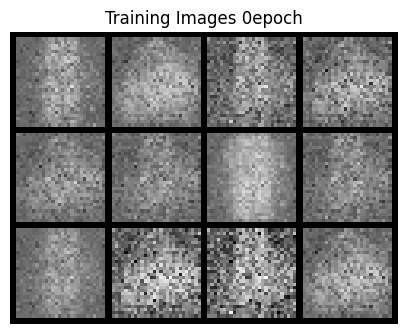

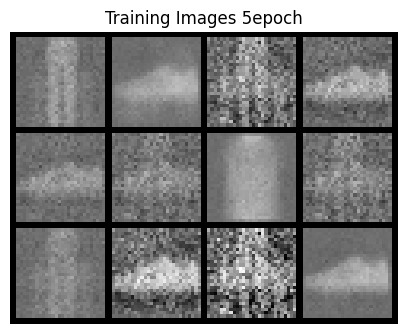

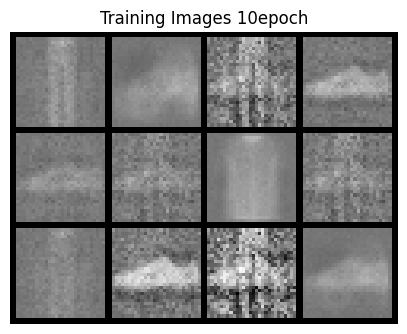

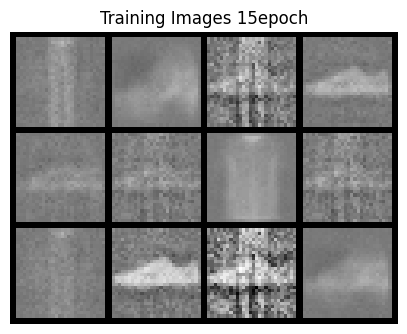

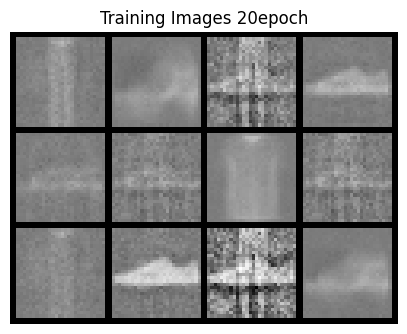

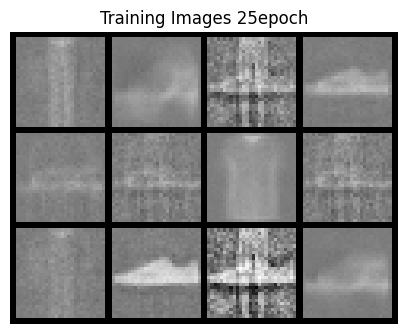

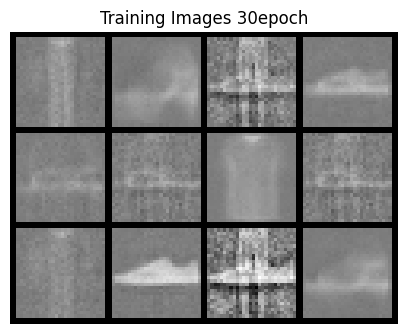

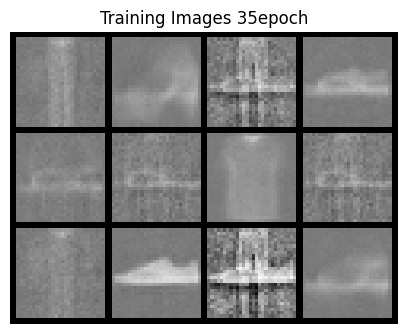

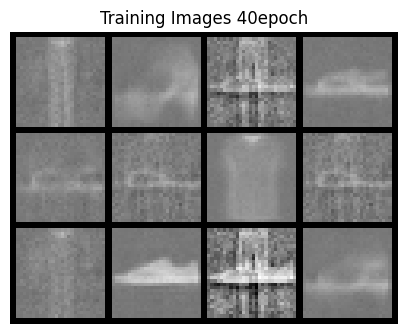

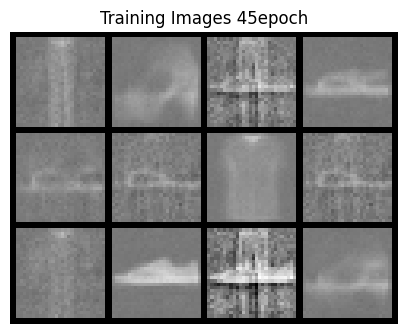

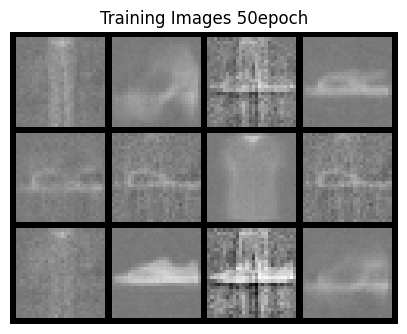

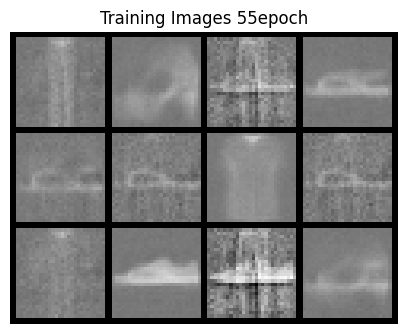

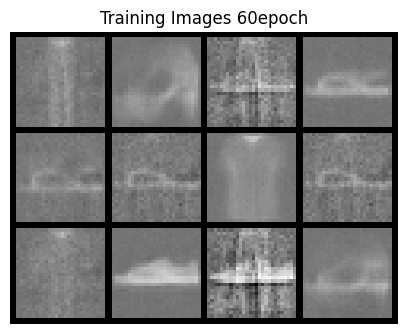

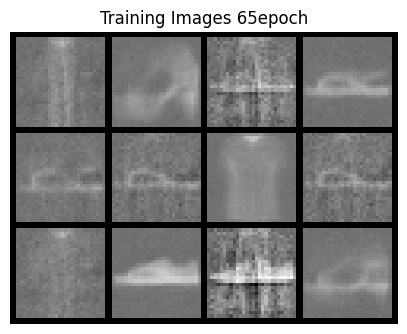

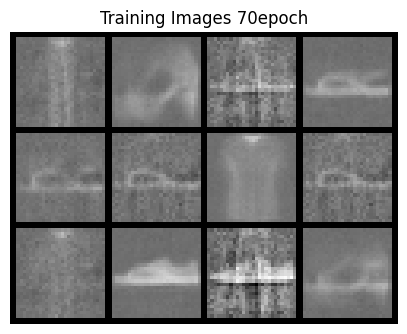

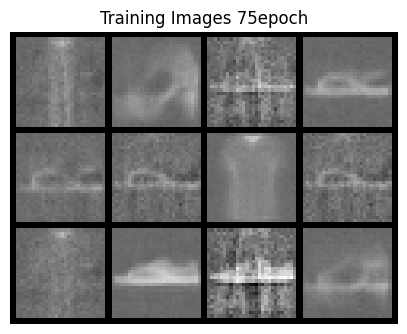

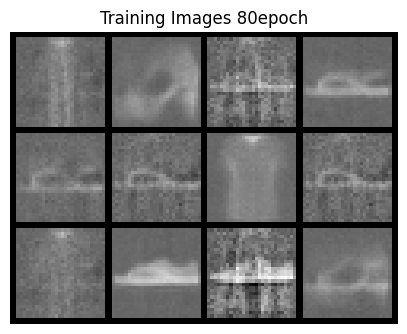

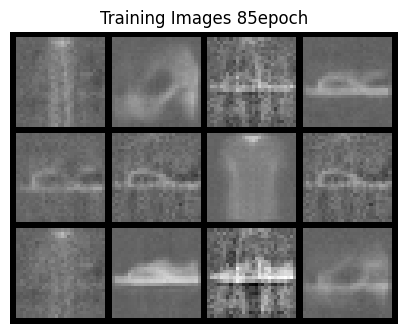

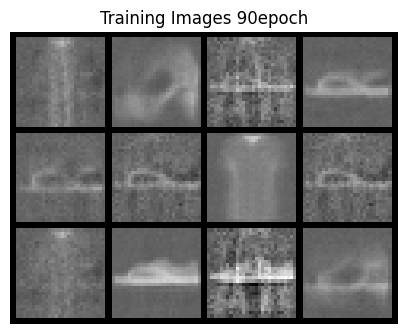

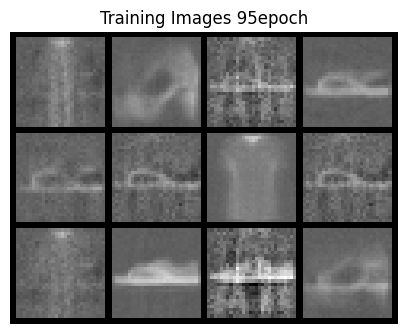

In [10]:
model.to(device)
generate_imgs = []
noise = torch.randn(batch_size, 2).to(device)
mse_list = []
kl_list = []
all_list = []

val_mse_list = []
val_kl_list = []
val_all_list = []
for epoch in range(EPOCHS):
    model.train()
    mse_loss = 0
    kl_loss = 0
    all_loss = 0
    for i, (imgs, _ ) in enumerate(train_loader):
        imgs = imgs.to(device)
        imgs = torch.flatten(imgs,1)
        optimizer.zero_grad()
        
        y , mean, log_var = model(imgs)
    
        mse = MSE_loss(y,imgs)
        kl = KL_loss(mean,log_var)
    
        loss = mse+ 0.001*kl
        loss.backward()
        optimizer.step()
        
        mse_loss += mse.item()    
        kl_loss += kl.item()    
        all_loss += loss.item() 
    
    mse_loss /=len(train_dataset)    
    kl_loss  /=len(train_dataset) 
    all_loss /=len(train_dataset) 
    
    print(f"{epoch} EPOCH - MSE : {mse_loss:.5f}, KL : {kl_loss:.5f}, ALL : {all_loss:.5f}")   
        
    mse_list.append(mse_loss)
    kl_list.append(kl_loss)
    all_list.append(all_loss)
    
    if (epoch % 5 == 0):
        with torch.no_grad():
            model.eval()
            val_mse_loss =0
            val_kl_loss =0
            val_all_loss =0
            
            for imgs, _ in val_loader:
                imgs = imgs.to(device)
                imgs = torch.flatten(imgs, 1)
        
                y, mean, log_var = model(imgs)
                
                mse = MSE_loss(y, imgs)
                kl = KL_loss(mean,log_var)
                
                loss = mse + kl
                
                val_mse_loss += mse.item()
                val_kl_loss += kl.item()
                val_all_loss += loss.item()
        
            val_mse_loss /=len(val_dataset.data)    
            val_kl_loss  /=len(val_dataset.data) 
            val_all_loss /=len(val_dataset.data)     
            
            print(f"     VAl - MSE : {mse_loss:.5f}, KL : {kl_loss:.5f}, ALL : {all_loss:.5f}")   
            
            val_mse_list.append(mse_loss)
            val_kl_list.append(kl_loss)
            val_all_list.append(all_loss)
    
        
            # noise를 통과시킨 decoder의 이미지를를 저장해둡니다
            fake = model.decoder(noise[:12]).detach().cpu().view(12,1,28,28)
            # std = torch.exp(log_var / 2)
            # latent = mean + std * noise
            # fake = model.decoder(latent[:12]).detach().cpu().view(-1, 1, 28, 28)
            generate_imgs.append(vutils.make_grid(fake, nrow=4, padding=2,normalize=True))
            plt.figure(figsize=(5,5))
            plt.axis("off")
            plt.title(f"Training Images {epoch}epoch")
            plt.imshow(np.transpose(generate_imgs[-1],(1,2,0)))
            plt.savefig(f'./gen_imgs/pretrain_{epoch}.png')

100


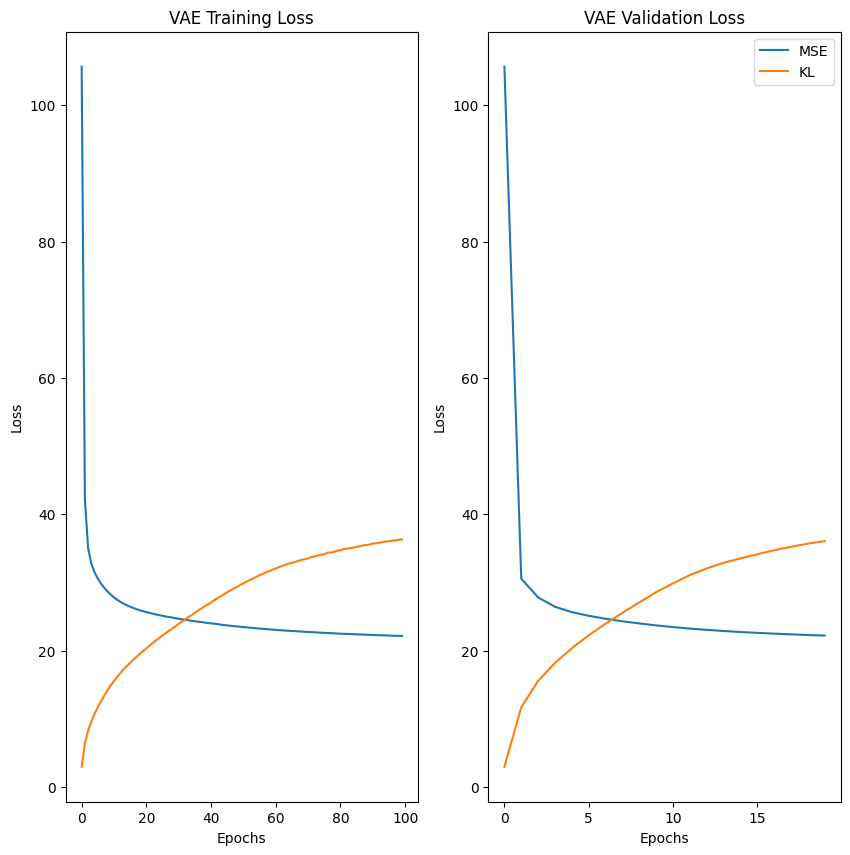

In [11]:
import matplotlib.pyplot as plt
print(len(mse_list))
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title(f"VAE Training Loss")
plt.plot(mse_list,label="MSE")
plt.plot(kl_list,label="KL")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title(f"VAE Validation Loss")
plt.plot(val_mse_list,label="MSE")
plt.plot(val_kl_list,label="KL")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

torch.Size([3, 92, 122])


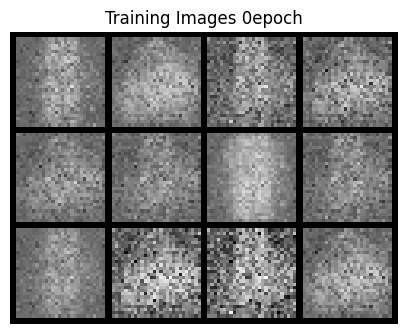

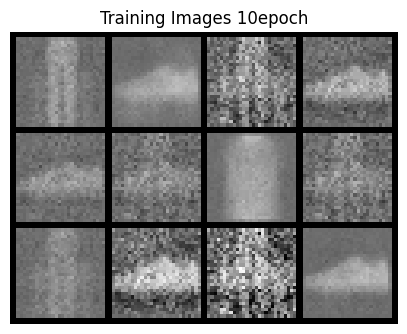

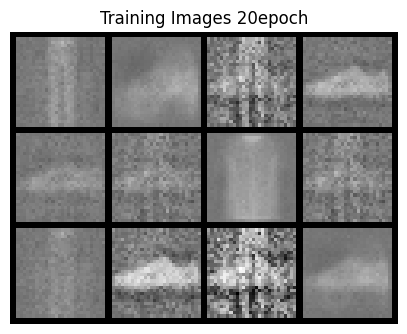

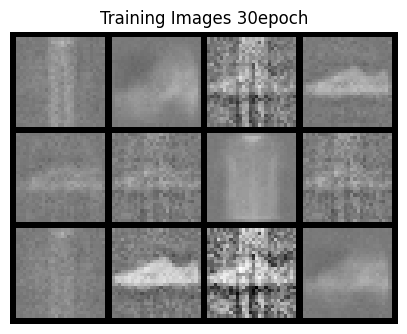

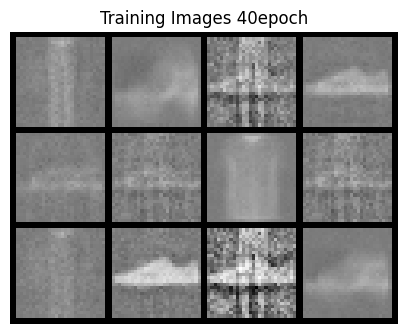

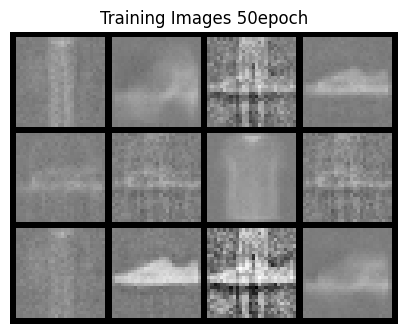

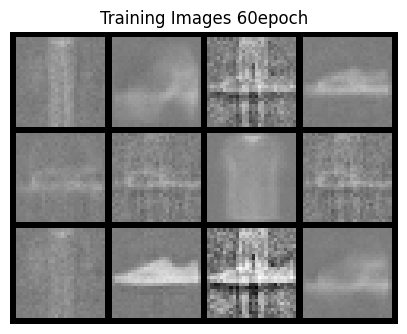

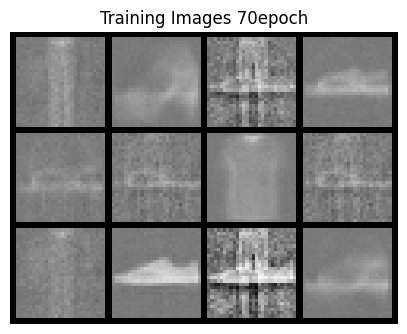

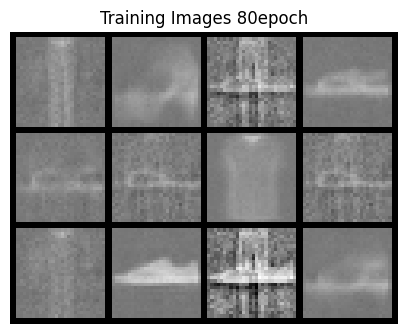

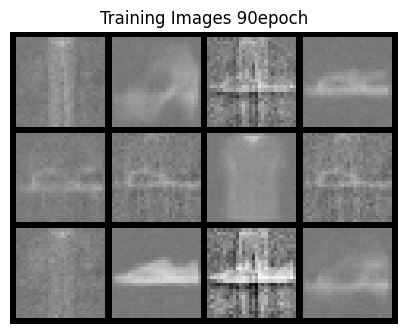

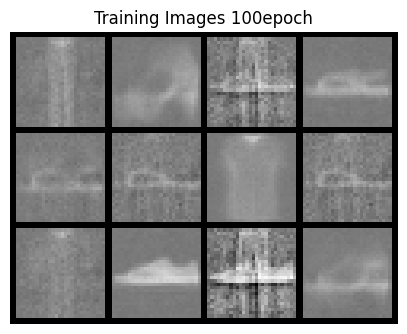

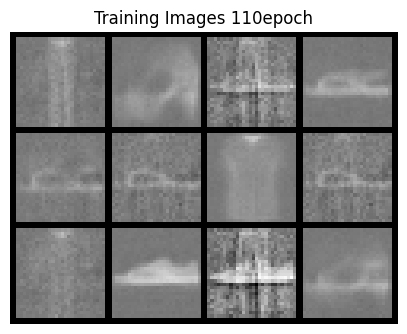

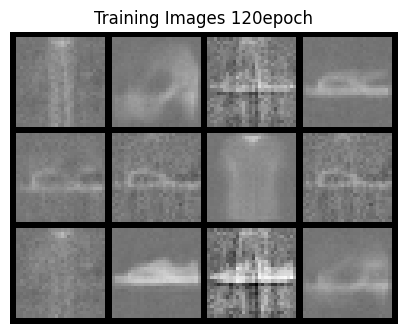

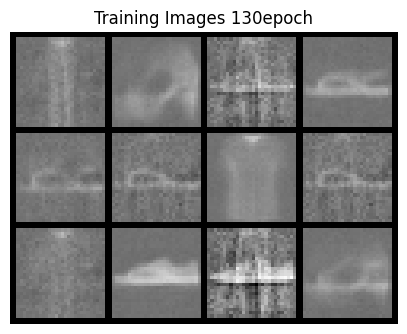

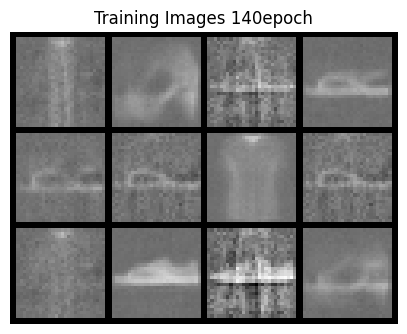

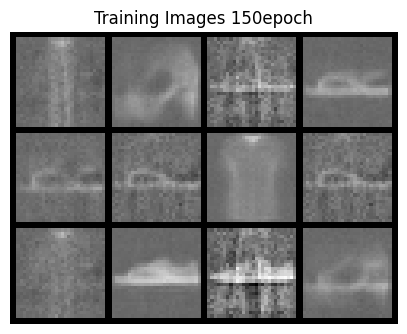

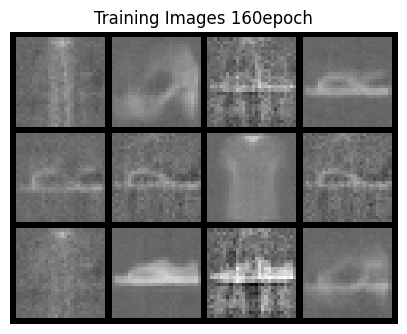

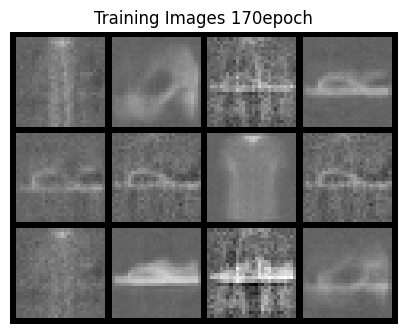

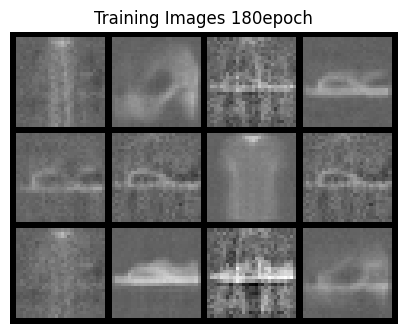

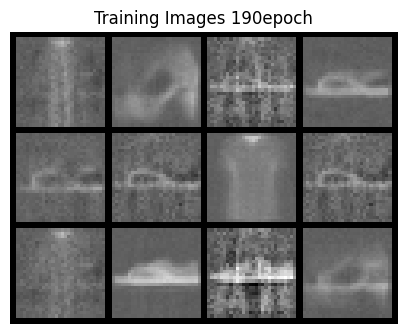

In [12]:
list_num = len(generate_imgs)
print(generate_imgs[0].shape)
for i in range(0,list_num,1):
    plt.figure(figsize=(5,5))
    target_i = i*10
    plt.axis("off")
    plt.title(f"Training Images {target_i}epoch")
    plt.imshow(np.transpose(generate_imgs[i],(1,2,0)))
